#### Functional enrichment analysis

should I specify background genes or not?

In [ ]:
import time
import timeit
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from tqdm import tqdm
from scipy.stats import mannwhitneyu
from collections import defaultdict

import gseapy
from gseapy import ringplot
from gseapy import barplot, dotplot

# transparent background
plt.rcParams.update({
    "figure.facecolor":  (0.0, 0.0, 0.0, 0.0),  
    "axes.facecolor":    (0.0, 0.0, 0.0, 0.0),  
})

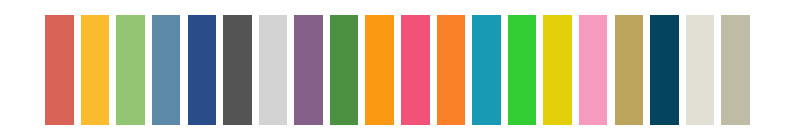

In [2]:
# define colors
purple = '#856088'
pink = '#F25278'
red = '#d96256'
lightgreen = '#93c572'
darkgreen = '#4c9141'
lightblue = '#5d8aa8'
darkblue = '#284d88'
white = '#fafafa'
lightgray = '#d3d3d3'
darkgray ='#545454'
lightorange = '#fabc2e'
darkorange = '#fb9912'
lightyellow = '#e4d00a'
lightgreen2 = '#32CD32'
lightblue2 = '#189AB4'
darkblue2 = '#05445E'
lightpink = '#F79AC0'
darkorange2 = '#FA8128'
darkyellow = '#BDA55D'
lightgray2 = '#E2E0D4'
lightgray3 = '#BFBBA4'

colors = [
    red, lightorange, lightgreen, lightblue, darkblue, 
    darkgray, lightgray, purple, darkgreen, darkorange,
    pink, darkorange2, lightblue2, lightgreen2, lightyellow,
    lightpink, darkyellow, darkblue2, lightgray2, lightgray3
]

plt.figure(figsize=(10, 1.5))
plt.bar(range(len(colors)), height=1, color=colors)
__ = plt.axis('off')

#### load data

In [3]:
# load ells est
fn = '../ella/output_ella/ella_merfish_mouse_brain.pkl'
res_dict = pd.read_pickle(fn)
types_list = res_dict['types_list']
genes_dict = res_dict['genes_dict']
cells_dict = res_dict['cells_dict']
p_fdr_dict = res_dict['p_fdr_dict']
score_dict = res_dict['score_dict']
lam_dict = res_dict['lam_dict']
label_dict = res_dict['label_dict']
del res_dict

#### enrichr 

In [4]:
# list available mouse genesets
gseapy.get_library_name(organism='Mouse')

['ARCHS4_Cell-lines',
 'ARCHS4_IDG_Coexp',
 'ARCHS4_Kinases_Coexp',
 'ARCHS4_TFs_Coexp',
 'ARCHS4_Tissues',
 'Achilles_fitness_decrease',
 'Achilles_fitness_increase',
 'Aging_Perturbations_from_GEO_down',
 'Aging_Perturbations_from_GEO_up',
 'Allen_Brain_Atlas_10x_scRNA_2021',
 'Allen_Brain_Atlas_down',
 'Allen_Brain_Atlas_up',
 'Azimuth_2023',
 'Azimuth_Cell_Types_2021',
 'BioCarta_2013',
 'BioCarta_2015',
 'BioCarta_2016',
 'BioPlanet_2019',
 'BioPlex_2017',
 'CCLE_Proteomics_2020',
 'CORUM',
 'COVID-19_Related_Gene_Sets',
 'COVID-19_Related_Gene_Sets_2021',
 'Cancer_Cell_Line_Encyclopedia',
 'CellMarker_2024',
 'CellMarker_Augmented_2021',
 'ChEA_2013',
 'ChEA_2015',
 'ChEA_2016',
 'ChEA_2022',
 'Chromosome_Location',
 'Chromosome_Location_hg19',
 'ClinVar_2019',
 'DSigDB',
 'Data_Acquisition_Method_Most_Popular_Genes',
 'DepMap_WG_CRISPR_Screens_Broad_CellLines_2019',
 'DepMap_WG_CRISPR_Screens_Sanger_CellLines_2019',
 'Descartes_Cell_Types_and_Tissue_2021',
 'Diabetes_Perturbatio

In [5]:
# select genesets
genesets_selected = [
    'GO_Biological_Process_2021',
    'GO_Cellular_Component_2021',
    'GO_Molecular_Function_2021',
    'KEGG_2019_Mouse',
#     'ARCHS4_TFs_Coexp',
#     'Chromosome_Location', # nonsig
#     'Chromosome_Location_hg19', # nonsig    
#     'WikiPathways_2019_Mouse',
#     'InterPro_Domains_2019',
#     'Pfam_Domains_2019',
#     'Pfam_InterPro_Domains', # not applicable
#     'lncHUB_lncRNA_Co-Expression',
#     'miRTarBase_2017' # nonsig
#     'ENCODE_TF_ChIP-seq_2015',
]
print(f'#gs selected={len(genesets_selected)}')

#gs selected=4


#### all types together

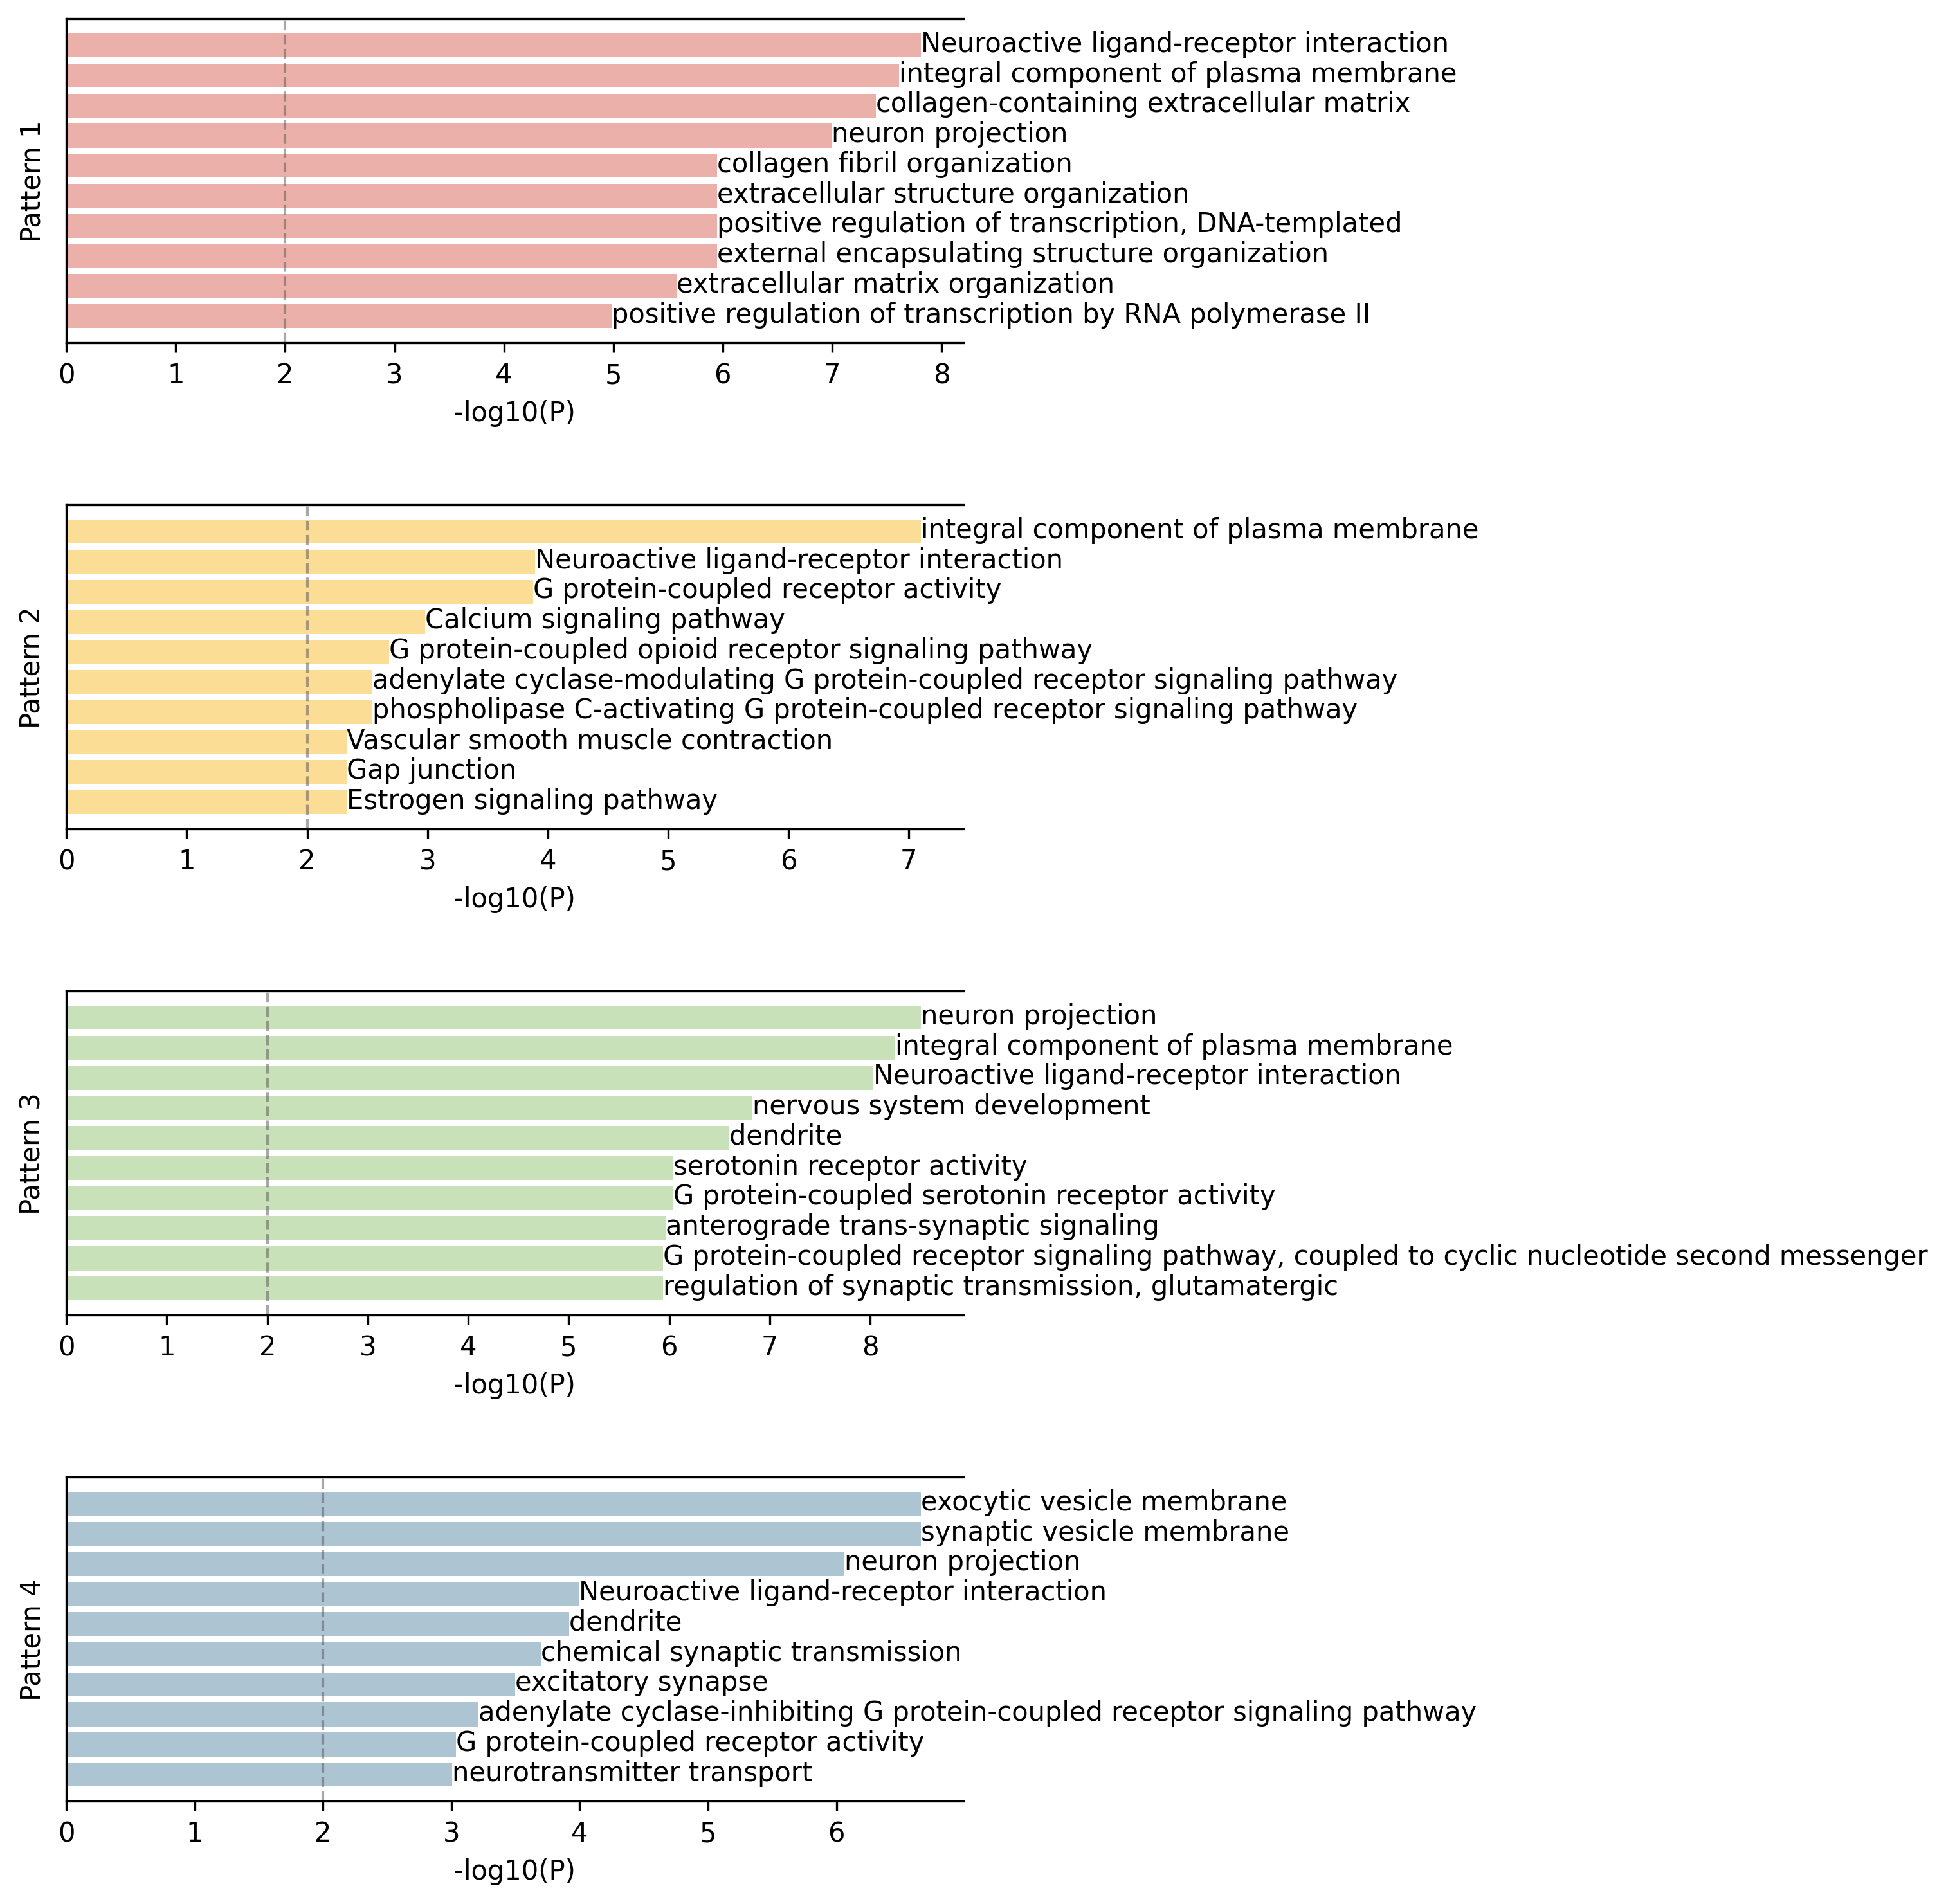

In [6]:
# results plots

N = 10 # <<< num of tops sets to show
colors = [red, lightorange, lightgreen, lightblue]
labels_all = np.concatenate(list(label_dict.values()), axis=0) 
genes_all = np.concatenate(list(genes_dict.values()), axis=0) 

nr = 4 
nc = 1
ss_nr = 3
ss_nc = 6
fig = plt.figure(figsize=(nc*ss_nc, nr*ss_nr), dpi=300)
gs = fig.add_gridspec(nr,nc,
                      width_ratios=[1]*nc,
                      height_ratios=[1]*nr)
gs.update(wspace=0.0, hspace=0.5)

for k in [0,1,2,3]:
    ax = plt.subplot(gs[k, 0])
    
    genes_k = genes_all[labels_all==k] 
    enr_k = gseapy.enrichr(
        gene_list = genes_k.tolist(),
        gene_sets = genesets_selected,
        background = genes_all.tolist(), 
        organism='Mouse',
        outdir=None
    )
    
    res_k = enr_k.results.sort_values('Adjusted P-value')
    set_labels_k = res_k.Gene_set.values
    ratios_k = res_k.Overlap.values
    set_size_k = []
    set_overlap_k = []
    for r in ratios_k:
        r1, r2 = r.split('/')
        set_size_k.append(r1)
        set_overlap_k.append(r2)
    set_size_k = np.array(set_size_k)
    set_overlap_k = np.array(set_overlap_k)
    term_k = res_k.Term.values
    pv_k = res_k['Adjusted P-value'].values
    log10pv_k = -np.log10(pv_k)
    
    ss = set_labels_k[:N]
    tt = term_k[:N]
    y_value = term_k[:N]
    y_pos = np.flip(np.arange(N))
    x_value = log10pv_k[:N]
    
    ax.barh(y_pos, 
            x_value, 
            color = colors[k],
            alpha=0.5,
            align='center')
    
    for i in range(N): # add geneset names
        tt_i = tt[i]
        set_name_i = (tt_i.split('('))[0]
        ax.text(x_value[i], y_pos[i]-0.2, set_name_i, ha='left', c='k', fontsize=10) 
    ax.spines['right'].set_visible(False)
    ax.set_yticks([])
    ax.axvline(x = 2, color = darkgray, lw=1, alpha=0.5, linestyle='dashed') # line at -log10p=2
    ax.set_ylabel(f'Pattern {k+1}')
    ax.set_xlabel(f'-log10(P)')
    
# plt.savefig(f'figs/fig_fea_all.pdf', dpi=300, bbox_inches='tight')

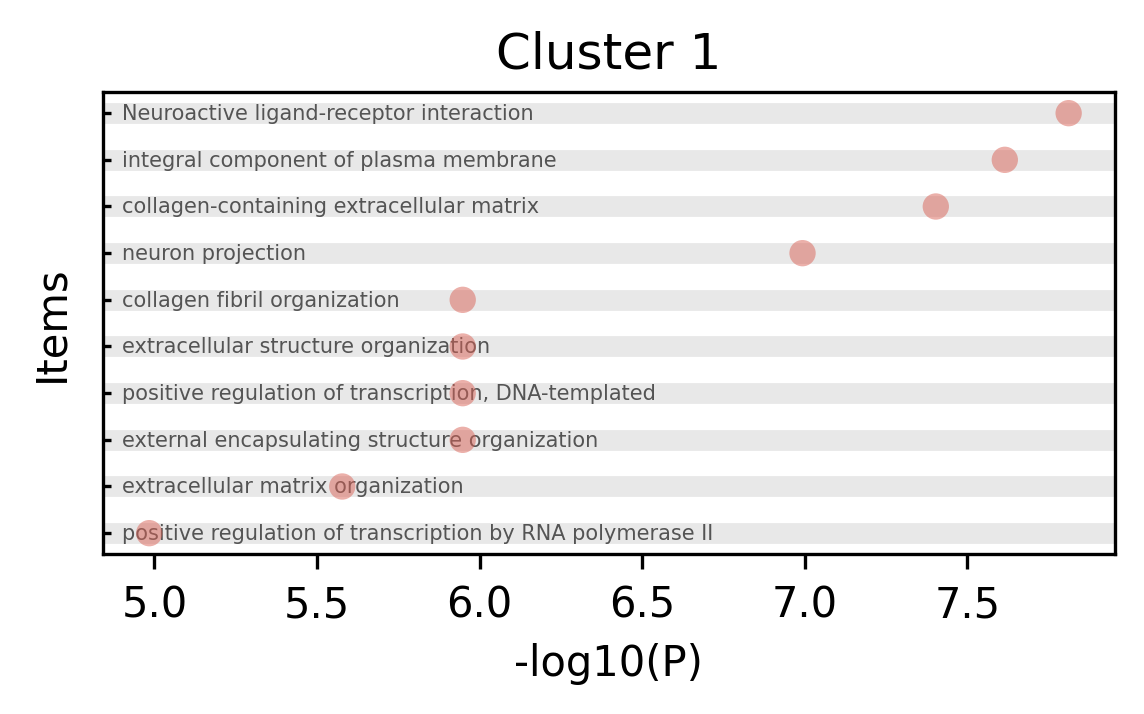

In [22]:
# results plots -- cluster 1

N = 10 # <<< num of tops sets to show
colors = [red, lightorange, lightgreen, lightblue]
labels_all = np.concatenate(list(label_dict.values()), axis=0) 
genes_all = np.concatenate(list(genes_dict.values()), axis=0) 

nr = 1 
nc = 1
ss_nr = 2
ss_nc = 4.35
fig = plt.figure(figsize=(nc*ss_nc, nr*ss_nr), dpi=300)
gs = fig.add_gridspec(nr,nc,
                      width_ratios=[1]*nc,
                      height_ratios=[1]*nr)
gs.update(wspace=0.0, hspace=0.0)
ax = plt.subplot(gs[0, 0])

for k in [0]:    
    genes_k = genes_all[labels_all==k] 
    enr_k = gseapy.enrichr(
        gene_list = genes_k.tolist(),
        gene_sets = genesets_selected,
        background = genes_all.tolist(),
        organism='Mouse',
        outdir=None
    )
    
    res_k = enr_k.results.sort_values('Adjusted P-value')
    set_labels_k = res_k.Gene_set.values
    ratios_k = res_k.Overlap.values
    set_size_k = []
    set_overlap_k = []
    for r in ratios_k:
        r1, r2 = r.split('/')
        set_size_k.append(r1)
        set_overlap_k.append(r2)
    set_size_k = np.array(set_size_k)
    set_overlap_k = np.array(set_overlap_k)
    term_k = res_k.Term.values
    pv_k = res_k['Adjusted P-value'].values
    log10pv_k = -np.log10(pv_k)
    
    ss = set_labels_k[:N]
    tt = term_k[:N]
    x_value = term_k[:N]
    x_pos = np.flip(np.arange(1,N+1,1))
    y_value = log10pv_k[:N]
    
    ax.scatter(y_value,
               x_pos,  
               color = colors[k],
               zorder=3,
               marker='.',
               edgecolor='none',
               s = 160, 
               alpha=0.5)
    
    for i in range(N): # add geneset names
        tt_i = tt[i]
        set_name_i = (tt_i.split('('))[0]
        ax.text(4.9, x_pos[i], set_name_i, 
                ha='left', va='center', 
                zorder=2,
                c=darkgray, fontsize=5) 
        ax.axhline(y=x_pos[i], 
                   zorder=1,
                   color=lightgray, lw=5, alpha=0.5)
        
    ax.set_yticks(np.arange(N,0,-1), ['']*N)
    ax.tick_params(axis='y', direction='in', length=2)
    ax.set_title(f'Cluster {k+1}')
    ax.set_xlabel('-log10(P)')
    ax.set_ylabel('Items')
    
# plt.savefig(f'figs/fig_fea_k{k}.pdf', dpi=300, bbox_inches='tight')

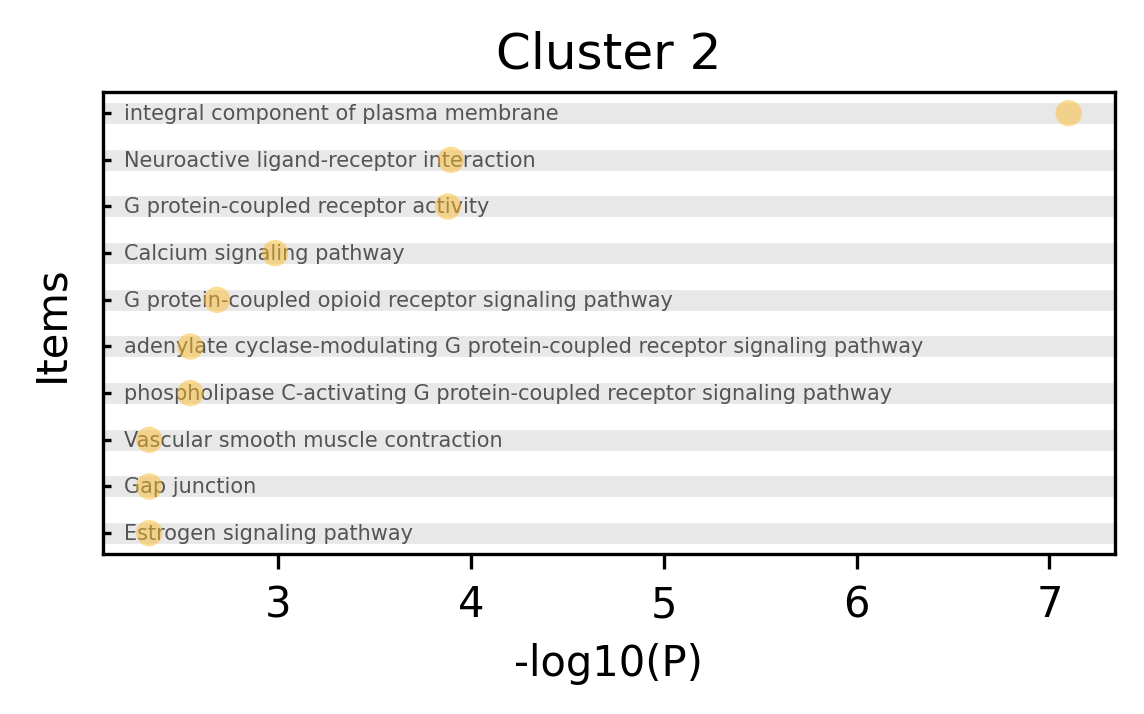

In [23]:
# results plots -- cluster 2

N = 10 # <<< num of tops sets to show
colors = [red, lightorange, lightgreen, lightblue]
labels_all = np.concatenate(list(label_dict.values()), axis=0) 
genes_all = np.concatenate(list(genes_dict.values()), axis=0) 

nr = 1 
nc = 1
ss_nr = 2
ss_nc = 4.35
fig = plt.figure(figsize=(nc*ss_nc, nr*ss_nr), dpi=300)
gs = fig.add_gridspec(nr,nc,
                      width_ratios=[1]*nc,
                      height_ratios=[1]*nr)
gs.update(wspace=0.0, hspace=0.0)
ax = plt.subplot(gs[0, 0])

for k in [1]:    
    genes_k = genes_all[labels_all==k]
    enr_k = gseapy.enrichr(
        gene_list = genes_k.tolist(),
        gene_sets = genesets_selected,
        background = genes_all.tolist(),
        organism='Mouse',
        outdir=None
    )
    
    res_k = enr_k.results.sort_values('Adjusted P-value')
    set_labels_k = res_k.Gene_set.values
    ratios_k = res_k.Overlap.values
    set_size_k = []
    set_overlap_k = []
    for r in ratios_k:
        r1, r2 = r.split('/')
        set_size_k.append(r1)
        set_overlap_k.append(r2)
    set_size_k = np.array(set_size_k)
    set_overlap_k = np.array(set_overlap_k)
    term_k = res_k.Term.values
    pv_k = res_k['Adjusted P-value'].values
    log10pv_k = -np.log10(pv_k)
    
    ss = set_labels_k[:N]
    tt = term_k[:N]
    x_value = term_k[:N]
    x_pos = np.flip(np.arange(1,N+1,1))
    y_value = log10pv_k[:N]
    
    ax.scatter(y_value,
               x_pos,  
               color = colors[k],
               zorder=3,
               marker='.',
               edgecolor='none',
               s = 160, 
               alpha=0.5)
    
    for i in range(N): # add geneset names
        tt_i = tt[i]
        set_name_i = (tt_i.split('('))[0]
        ax.text(2.2, x_pos[i], set_name_i, 
                ha='left', va='center', 
                zorder=2,
                c=darkgray, fontsize=5) 
        ax.axhline(y=x_pos[i], 
                   zorder=1,
                   color=lightgray, lw=5, alpha=0.5)
        
    ax.set_yticks(np.arange(N,0,-1), ['']*N)
    ax.tick_params(axis='y', direction='in', length=2)    
    ax.set_title(f'Cluster {k+1}')
    ax.set_xlabel('-log10(P)')
    ax.set_ylabel('Items')
    
# plt.savefig(f'figs/fig_fea_k{k}.pdf', dpi=300, bbox_inches='tight')

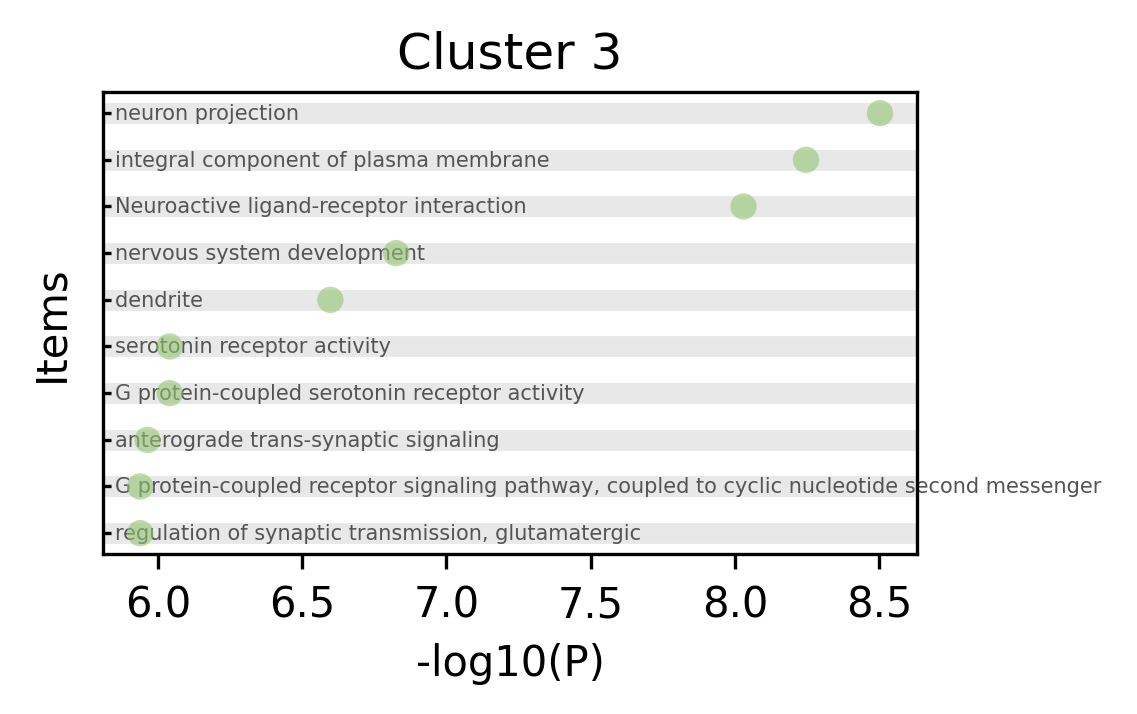

In [40]:
# results plots -- cluster 3

N = 10 # <<< num of tops sets to show
colors = [red, lightorange, lightgreen, lightblue]
labels_all = np.concatenate(list(label_dict.values()), axis=0) 
genes_all = np.concatenate(list(genes_dict.values()), axis=0) 

nr = 1 
nc = 1
ss_nr = 2
ss_nc = 3.5
fig = plt.figure(figsize=(nc*ss_nc, nr*ss_nr), dpi=300)
gs = fig.add_gridspec(nr,nc,
                      width_ratios=[1]*nc,
                      height_ratios=[1]*nr)
gs.update(wspace=0.0, hspace=0.0)
ax = plt.subplot(gs[0, 0])

for k in [2]:    
    genes_k = genes_all[labels_all==k]
    enr_k = gseapy.enrichr(
        gene_list = genes_k.tolist(),
        gene_sets = genesets_selected,
        background = genes_all.tolist(),
        organism='Mouse',
        outdir=None
    )
    
    res_k = enr_k.results.sort_values('Adjusted P-value')
    set_labels_k = res_k.Gene_set.values
    ratios_k = res_k.Overlap.values
    set_size_k = []
    set_overlap_k = []
    for r in ratios_k:
        r1, r2 = r.split('/')
        set_size_k.append(r1)
        set_overlap_k.append(r2)
    set_size_k = np.array(set_size_k)
    set_overlap_k = np.array(set_overlap_k)
    term_k = res_k.Term.values
    pv_k = res_k['Adjusted P-value'].values
    log10pv_k = -np.log10(pv_k)
    
    ss = set_labels_k[:N]
    tt = term_k[:N]
    x_value = term_k[:N]
    x_pos = np.flip(np.arange(1,N+1,1))
    y_value = log10pv_k[:N]
    
    ax.scatter(y_value,
               x_pos,  
               color = colors[k],
               zorder=3,
               marker='.',
               edgecolor='none',
               s = 160, 
               alpha=0.6)
    
    for i in range(N): # add geneset names
        tt_i = tt[i]
        set_name_i = (tt_i.split('('))[0]
        ax.text(5.85, x_pos[i], set_name_i, 
                ha='left', va='center', 
                zorder=2,
                c=darkgray, fontsize=5) 
        ax.axhline(y=x_pos[i], 
                   zorder=1,
                   color=lightgray, lw=5, alpha=0.5)
        
    ax.set_yticks(np.arange(N,0,-1), ['']*N)
    ax.tick_params(axis='y', direction='in', length=2)
    ax.set_title(f'Cluster {k+1}')
    ax.set_xlabel('-log10(P)')
    ax.set_ylabel('Items')

# plt.savefig(f'figs/fig_fea_k{k}.pdf', dpi=300, bbox_inches='tight')

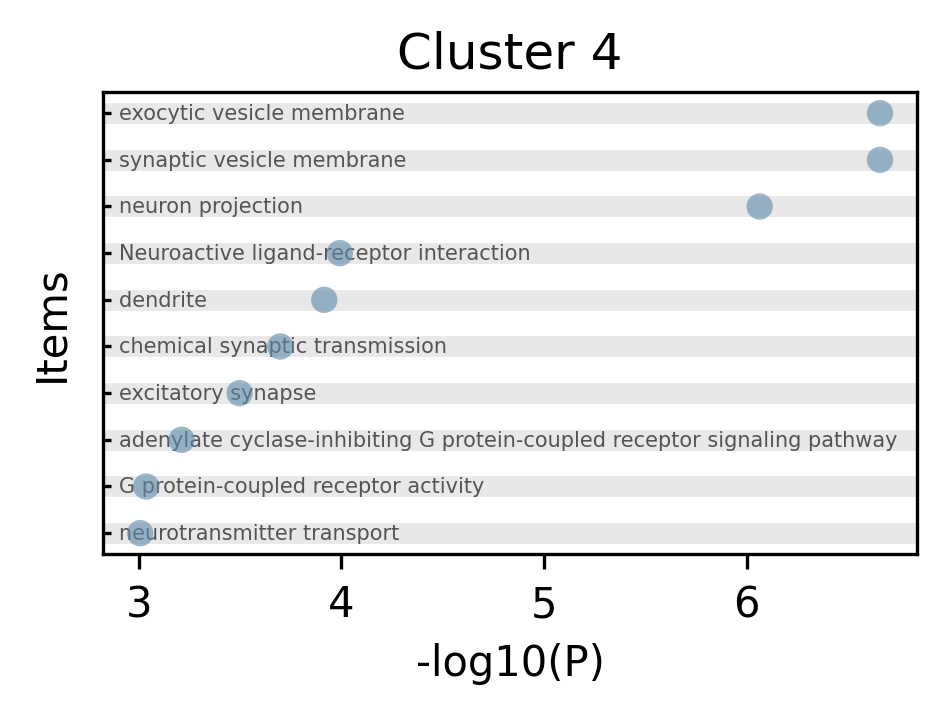

In [41]:
# results plots -- cluster 4

N = 10 # <<< num of tops sets to show
colors = [red, lightorange, lightgreen, lightblue]
labels_all = np.concatenate(list(label_dict.values()), axis=0) 
genes_all = np.concatenate(list(genes_dict.values()), axis=0) 

nr = 1 
nc = 1
ss_nr = 2
ss_nc = 3.5
fig = plt.figure(figsize=(nc*ss_nc, nr*ss_nr), dpi=300)
gs = fig.add_gridspec(nr,nc,
                      width_ratios=[1]*nc,
                      height_ratios=[1]*nr)
gs.update(wspace=0.0, hspace=0.0)
ax = plt.subplot(gs[0, 0])

for k in [3]:    
    genes_k = genes_all[labels_all==k] 
    enr_k = gseapy.enrichr(
        gene_list = genes_k.tolist(),
        gene_sets = genesets_selected,
        background = genes_all.tolist(),
        organism='Mouse',
        outdir=None
    )
    
    res_k = enr_k.results.sort_values('Adjusted P-value')
    set_labels_k = res_k.Gene_set.values
    ratios_k = res_k.Overlap.values
    set_size_k = []
    set_overlap_k = []
    for r in ratios_k:
        r1, r2 = r.split('/')
        set_size_k.append(r1)
        set_overlap_k.append(r2)
    set_size_k = np.array(set_size_k)
    set_overlap_k = np.array(set_overlap_k)
    term_k = res_k.Term.values
    pv_k = res_k['Adjusted P-value'].values
    log10pv_k = -np.log10(pv_k)
    
    ss = set_labels_k[:N]
    tt = term_k[:N]
    x_value = term_k[:N]
    x_pos = np.flip(np.arange(1,N+1,1))
    y_value = log10pv_k[:N]
    
    ax.scatter(y_value,
               x_pos,  
               color = colors[k],
               zorder=3,
               marker='.',
               edgecolor='none',
               s = 160, 
               alpha=0.6)
    
    for i in range(N): # add geneset names
        tt_i = tt[i]
        set_name_i = (tt_i.split('('))[0]
        ax.text(2.9, x_pos[i], set_name_i, 
                ha='left', va='center', 
                zorder=2,
                c=darkgray, fontsize=5) 
        ax.axhline(y=x_pos[i],
                   zorder=1,
                   color=lightgray, lw=5, alpha=0.5)
        
    ax.set_yticks(np.arange(N,0,-1), ['']*N)
    ax.tick_params(axis='y', direction='in', length=2)
    ax.set_title(f'Cluster {k+1}')
    ax.set_xlabel('-log10(P)')
    ax.set_ylabel('Items')

# plt.savefig(f'figs/fig_fea_k{k}.pdf', dpi=300, bbox_inches='tight')